(sec_guide_features)=
# Feature matrices

This page provides a visual tour of the feature matrices provided
by Dinf.

## Model

To observe how changes to various variables will change the
resulting feature matrices, we define a `sim()` function.
This function is derived from the generator function of the bottleneck model
we've seen previously, and returns a feature matrix.

In [1]:
import demes
import msprime
import numpy as np

import dinf


bottleneck_model = demes.loads(
    """
    description: Two-epoch model with recent bottleneck.
    time_units: generations
    demes:
      - name: A
        epochs:
          - start_size: 10000
            end_time: 100
          - start_size: 1000
            end_time: 0
    """
)


def sim(seed, features, num_individuals, sequence_length):
    rng = np.random.default_rng(seed)
    seed1, seed2 = rng.integers(low=1, high=2**31, size=2)

    recombination_rate = 1.25e-8
    mutation_rate = 1.25e-8

    ts = msprime.sim_ancestry(
        samples=num_individuals,
        demography=msprime.Demography.from_demes(bottleneck_model),
        sequence_length=sequence_length,
        recombination_rate=recombination_rate,
        random_seed=seed1,
        record_provenance=False,
    )
    ts = msprime.sim_mutations(ts, rate=mutation_rate, random_seed=seed2)

    feature_matrix = features.from_ts(ts)
    return feature_matrix

## Plotting a feature

We'll also need some code to plot the feature matrices.

In [2]:
# Use SVG as the output format for notebooks.
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

import matplotlib
import matplotlib.pyplot as plt


def plot_feature(M, ax, channel=0, cb_label="Minor alleles"):
    """Plot a feature matrix."""
    if channel == 0:
        cmap = matplotlib.cm.get_cmap("viridis", int(1 + np.max(M)))
    else:
        cmap = "plasma"
    im = ax.imshow(
        M[..., channel],
        interpolation="none",
        origin="lower",
        rasterized=True,
        # left, right, bottom, top
        extent=(0, M.shape[1], 0, M.shape[0]),
        aspect="auto",
        cmap=cmap,
    )
    ax.set_ylabel("individuals")
    ax.set_xlabel("loci")
    for sp in ("top", "right", "bottom", "left"):
        ax.spines[sp].set_visible(False)

    cb = ax.figure.colorbar(im, ax=ax, pad=0.02, fraction=0.04, label=cb_label)
    # Prefer integer ticks.
    cb.ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

    return ax


def get_axes(nrows, ncols, scale=0.75, aspect=9 / 16, **kwargs):
    """Build subplot axes."""
    w, h = scale * plt.figaspect(aspect)
    _, axs = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(ncols * w, nrows * h), tight_layout=True,
    )
    if (nrows, ncols) == (1, 1):
        axs = np.array([axs])
    for ax in axs.flat:
        # Get the ticklabels back for the shared axis.
        ax.xaxis.set_tick_params(labelbottom=True)
        # Prefer integer ticks.
        ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    return axs

## Binned versus unbinned

Dinf supports two styles of feature matrices,
which encode information about genotypes in different ways.

{class}`.HaplotypeMatrix` takes the central `num_loci`
SNPs and encodes the minor allele as a `1`. For unphased data, genotypes
are summed across the chromosome copies, so matrix entries for diploid
individuals may be `0`, `1`, or `2`.
If there are fewer than `num_loci` SNPs in the genomic window, the matrix
is padded on either side with zeros.
In addition, {class}`.HaplotypeMatrix` uses two channels---effectively two
matrices---the first is the genotype matrix and the second is a matrix of
inter-SNP distances, which is repeated for each haplotype/individual.
Each inter-SNP distance is relative to the size of the genomic window,
and distances are encoded as 32 bit floats (the numpy dtype is `float32`).
Note that the two channels of the feature matrices share the dtype.

{class}`.BinnedHaplotypeMatrix` partitions the genomic window into `num_loci`
bins and counts minor alles for SNPs observed in each bin. For unphased data,
genotypes are summed across the chromosome copies.
The binning approach maintains information about the spatial distribution of
SNP along the genomic window and thus doesn't need to encode inter-SNP
distances separately.
The magnitude of the matrix entries are driven by the density of segregating
sites relative to the size of each bin.
{class}`.BinnedHaplotypeMatrix` uses 8 bit integers for the allele counts
(the numpy dtype is `int8`), which leads to a compact in-memory representation
(8 times smaller than an equivalent {class}`.HaplotypeMatrix`).

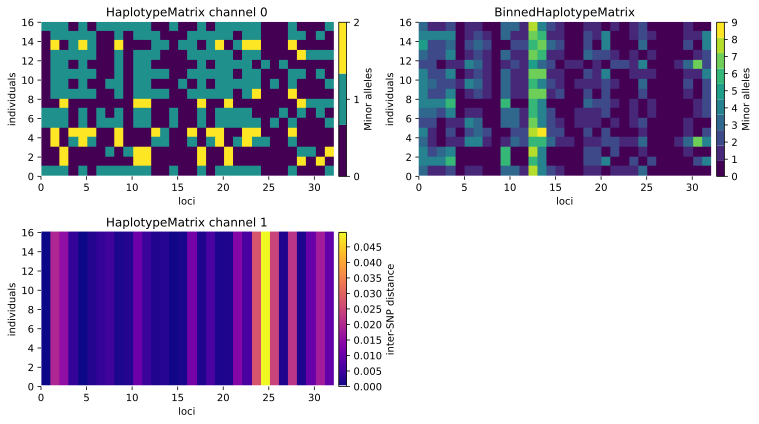

In [3]:
sequence_length = 50_000
num_individuals = 16
hm_features = dinf.HaplotypeMatrix(
    num_individuals=num_individuals,
    num_loci=32,
    ploidy=2,
    phased=False,
    maf_thresh=0.05,
)
bhm_features = dinf.BinnedHaplotypeMatrix(
    num_individuals=num_individuals,
    num_loci=32,
    ploidy=2,
    phased=False,
    maf_thresh=0.05,
)

axs = get_axes(nrows=2, ncols=2, sharex="col", sharey="row")
axs[1, 1].set_axis_off()

M1 = sim(
    seed=2,
    features=hm_features,
    num_individuals=num_individuals,
    sequence_length=sequence_length
)
ax = plot_feature(M1, ax=axs[0, 0])
ax.set_title("HaplotypeMatrix channel 0")
ax = plot_feature(M1, ax=axs[1, 0], channel=1, cb_label="inter-SNP distance")
ax.set_title("HaplotypeMatrix channel 1")

M2 = sim(
    seed=2,
    features=bhm_features,
    num_individuals=num_individuals,
    sequence_length=sequence_length
)
ax = plot_feature(M2, ax=axs[0, 1])
ax.set_title("BinnedHaplotypeMatrix");

## Sequence length

The sequence length for a feature matrix is the size of the genomic
window that was simulated or sampled from a vcf.

For {class}`.HaplotypeMatrix`, the sequence length should be sufficiently
long to obtain `num_loci` SNPs *most of the time*. If the feature matrices are
being padded regularly, the sequence length should be increased
(or `num_loci` decreased).
On the other hand, if the sequence length is too long (or `num_loci` too small),
most diversity in the genomic window will be discarded,
which would be an inefficient use of compute resources.

For {class}`.BinnedHaplotypeMatrix`, increasing the sequence length can
potentially extract longer range information than {class}`.HaplotypeMatrix`
(for a given `num_loci` value).
However, the density of SNPs needs to be considered to ensure that the
allele counts per bin don't overflow the 8 bit integer used to store the
counts. If overflow occurs regularly (i.e. for many entries in many feature
matrices), this may lead to information loss rather than information gain.

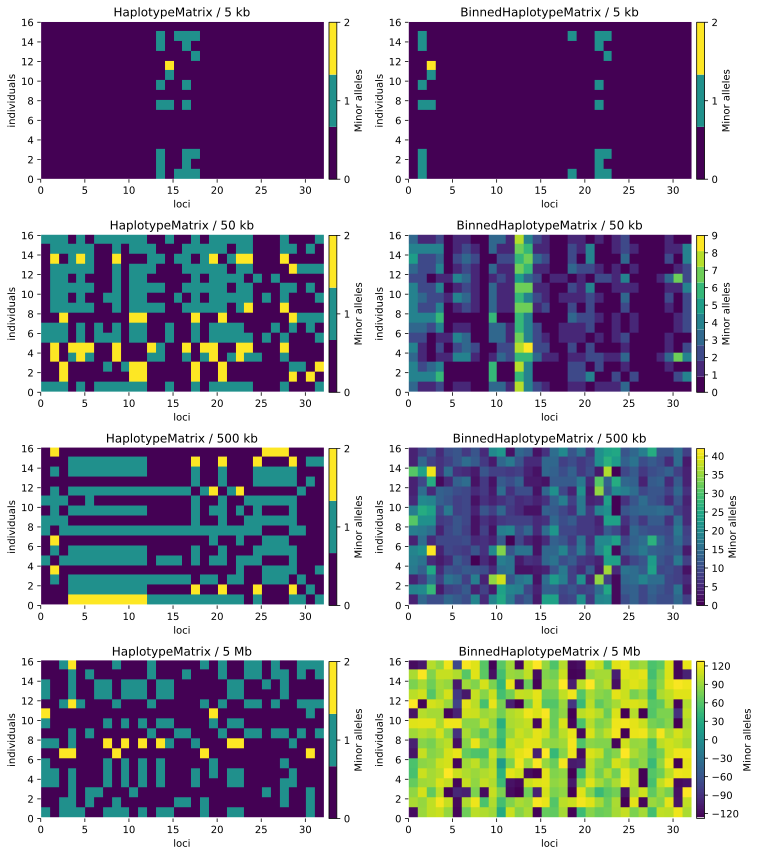

In [4]:
num_individuals = 16
hm_features = dinf.HaplotypeMatrix(
    num_individuals=num_individuals,
    num_loci=32,
    ploidy=2,
    phased=False,
    maf_thresh=0.05,
)

bhm_features = dinf.BinnedHaplotypeMatrix(
    num_individuals=num_individuals,
    num_loci=32,
    ploidy=2,
    phased=False,
    maf_thresh=0.05,
)

axs = get_axes(nrows=4, ncols=2, sharex="col", sharey="row")

for j, (sequence_length, label) in enumerate(
    zip((5_000, 50_000, 500_000, 5_000_000), ("5 kb", "50 kb", "500 kb", "5 Mb"))
):
    M1 = sim(
        seed=2,
        features=hm_features,
        num_individuals=num_individuals,
        sequence_length=sequence_length
    )
    ax = plot_feature(M1, ax=axs[j, 0])
    ax.set_title(f"HaplotypeMatrix / {label}")

    M2 = sim(
        seed=2,
        features=bhm_features,
        num_individuals=num_individuals,
        sequence_length=sequence_length
    )
    ax = plot_feature(M2, ax=axs[j, 1])
    ax.set_title(f"BinnedHaplotypeMatrix / {label}")

## Number of loci

Recall that the `num_loci` feature variable indicates the number of SNPs
for a {class}`.HaplotypeMatrix`, but indicates the number of genomic bins for a
{class}`.BinnedHaplotypeMatrix`.

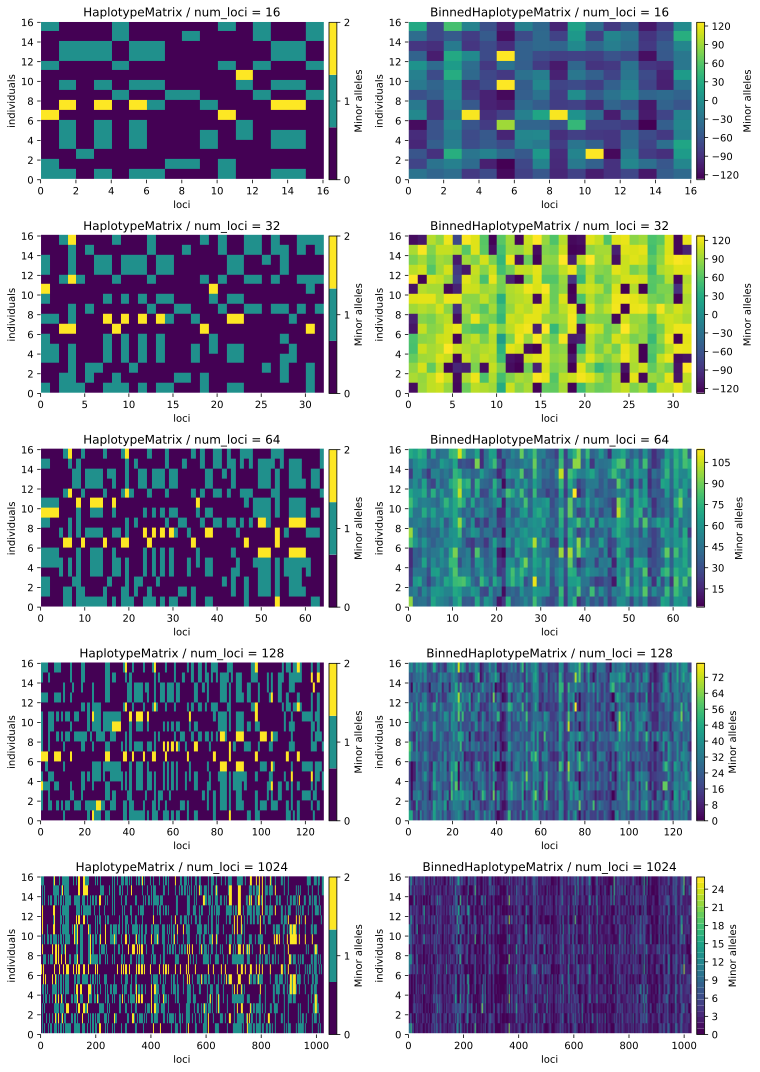

In [5]:
sequence_length = 5_000_000
num_individuals = 16

axs = get_axes(nrows=5, ncols=2, sharey="row")

for j, num_loci in enumerate((16, 32, 64, 128, 1024)):
    M1 = sim(
        seed=2,
        features=dinf.HaplotypeMatrix(
            num_individuals=num_individuals,
            num_loci=num_loci,
            ploidy=2,
            phased=False,
            maf_thresh=0.05,
        ),
        num_individuals=num_individuals,
        sequence_length=sequence_length
    )
    ax = plot_feature(M1, ax=axs[j, 0])
    ax.set_title(f"HaplotypeMatrix / num_loci = {num_loci}")

    M2 = sim(
        seed=2,
        features=dinf.BinnedHaplotypeMatrix(
            num_individuals=num_individuals,
            num_loci=num_loci,
            ploidy=2,
            phased=False,
            maf_thresh=0.05,
        ),
        num_individuals=num_individuals,
        sequence_length=sequence_length
    )
    ax = plot_feature(M2, ax=axs[j, 1])
    ax.set_title(f"BinnedHaplotypeMatrix / num_loci = {num_loci}")

## Multiple feature matrices

Dinf provides feature extraction classes {class}`.MultipleHaplotypeMatrices`
and {class}`.MultipleBinnedHaplotypeMatrices` that are simple extensions of
the {class}`.HaplotypeMatrix` and {class}`.BinnedHaplotypeMatrix` repectively.
The "Multiple" feature extraction classes produce a dictionary of features,
where each dictionary key is an arbitrary label and the value is the
feature matrix for that labelled collection of individuals.
The collections of individuals typically correspond to populations,
but this need not be the case.

Below, we show feature matrices for each of the demes in a two-deme
isolation-with-migration model. Each feature matrix in a given collection
may have different dimensions, i.e. different `num_loci`, and/or different
`num_individuals`. The ploidy may also differ between feature matrices,
leaving open the possibility of using "male" and "female" labels in conjunction
with sex chromosomes.
Note that MAF filtering is performed across all individuals, not within
labelled groups. Thus sites may be present in the matrices that represent
fixed differences between the labelled groups.

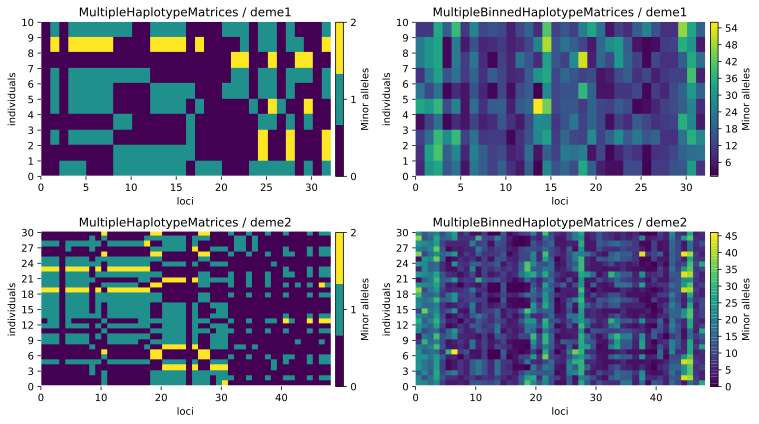

In [6]:
im_model = demes.loads(
    """
    description: Isolation with Migration
    time_units: generations
    doi:
      - Wang et al. 2021, https://doi.org/10.1111/1755-0998.13386
    demes:
      - name: ancestral
        epochs:
          - start_size: 15000
            end_time: 2000
      - name: deme1
        ancestors: [ancestral]
        epochs:
          - start_size: 9000
      - name: deme2
        ancestors: [ancestral]
        epochs:
          - start_size: 5000
    pulses:
      - sources: [deme1]
        dest: deme2
        time: 1000
        proportions: [0.05]
    """
)


def sim_im(seed, features, num_individuals, sequence_length):
    rng = np.random.default_rng(seed)
    seed1, seed2 = rng.integers(low=1, high=2**31, size=2)

    recombination_rate = 1.25e-8
    mutation_rate = 1.25e-8

    ts = msprime.sim_ancestry(
        samples=num_individuals,
        demography=msprime.Demography.from_demes(im_model),
        sequence_length=sequence_length,
        recombination_rate=recombination_rate,
        random_seed=seed1,
        record_provenance=False,
    )
    ts = msprime.sim_mutations(ts, rate=mutation_rate, random_seed=seed2)

    populations = num_individuals.keys()
    individuals = {pop: dinf.misc.ts_individuals(ts, pop) for pop in populations}
    labelled_features = features.from_ts(ts, individuals=individuals)
    return labelled_features


sequence_length = 500_000
num_individuals = dict(deme1=10, deme2=30)

hm_matrices, bhm_matrices = (
    cls(
        num_individuals=num_individuals,
        num_loci=dict(deme1=32, deme2=48),
        ploidy=dict(deme1=2, deme2=2),
        global_phased=False,
        global_maf_thresh=0.05,
    )
    for cls in (dinf.MultipleHaplotypeMatrices, dinf.MultipleBinnedHaplotypeMatrices)
)

axs = get_axes(nrows=2, ncols=2)

features1 = sim_im(
    seed=2,
    features=hm_matrices,
    num_individuals=num_individuals,
    sequence_length=sequence_length,
)
for j, (label, M) in enumerate(features1.items()):
    ax = plot_feature(M, ax=axs[j, 0])
    ax.set_title(f"MultipleHaplotypeMatrices / {label}")

features2 = sim_im(
    seed=2,
    features=bhm_matrices,
    num_individuals=num_individuals,
    sequence_length=sequence_length,
)
for j, (label, M) in enumerate(features2.items()):
    ax = plot_feature(M, ax=axs[j, 1])
    ax.set_title(f"MultipleBinnedHaplotypeMatrices / {label}")